In [8]:
import os
import numpy as np
from PIL import Image

data = 'archive/Garbage classification/Garbage classification'

## Here we created a test and train image generator using the dataset. 

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 100 # Leads to around 20 batches
target_size = (128, 96) # This is 1/3 the image shape

train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,validation_split=0.1,rescale=1./255,
                         shear_range = 0.1,zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test =ImageDataGenerator(rescale=1./255,validation_split=0.1)

train_generator = train.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)

test_generator = test.flow_from_directory(
    data,
    target_size=(128, 96),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## Here we try to find the best combination of convolutional filter numbers and layer numbers, testing out a few different options. 

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import ParameterGrid

def create_model(num_conv_layers, num_filters):
    labels = list(train_generator.class_indices.keys())
    num_classes = len(labels)
    model = models.Sequential()

    model.add(layers.Conv2D(8, (3, 3), padding='same', input_shape=(128, 96, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    for _ in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    return model

param_grid = {
    'num_conv_layers': [2, 3, 4],
    'num_filters': [16, 32, 64]
}

best_accuracy = 0
best_params = {}

for params in ParameterGrid(param_grid):
    num_conv_layers = params['num_conv_layers']
    num_filters = params['num_filters']
    
    model = create_model(num_conv_layers, num_filters)
    history = model.fit(train_generator, epochs=20, validation_data=test_generator)

    validation_accuracy = history.history['val_accuracy'][-1]
    print(f"Params: {params}, Validation Accuracy: {validation_accuracy}") 

    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

Epoch 1/20
23/23 [==============================] - 16s 664ms/step - loss: 1.6890 - accuracy: 0.2513 - val_loss: 1.5653 - val_accuracy: 0.3506
Epoch 2/20
23/23 [==============================] - 15s 630ms/step - loss: 1.5036 - accuracy: 0.3915 - val_loss: 1.4712 - val_accuracy: 0.3546
Epoch 3/20
23/23 [==============================] - 14s 627ms/step - loss: 1.3651 - accuracy: 0.4499 - val_loss: 1.3771 - val_accuracy: 0.4143
Epoch 4/20
23/23 [==============================] - 15s 633ms/step - loss: 1.2857 - accuracy: 0.5040 - val_loss: 1.2975 - val_accuracy: 0.4940
Epoch 5/20
23/23 [==============================] - 14s 626ms/step - loss: 1.1948 - accuracy: 0.5330 - val_loss: 1.2207 - val_accuracy: 0.5259
Epoch 6/20
23/23 [==============================] - 15s 628ms/step - loss: 1.1592 - accuracy: 0.5453 - val_loss: 1.2366 - val_accuracy: 0.5299
Epoch 7/20
23/23 [==============================] - 15s 628ms/step - loss: 1.1144 - accuracy: 0.5725 - val_loss: 1.2276 - val_accuracy: 0.5378

Epoch 17/20
23/23 [==============================] - 21s 895ms/step - loss: 0.9140 - accuracy: 0.6529 - val_loss: 1.2716 - val_accuracy: 0.5060
Epoch 18/20
23/23 [==============================] - 20s 844ms/step - loss: 0.8787 - accuracy: 0.6762 - val_loss: 1.0965 - val_accuracy: 0.5657
Epoch 19/20
23/23 [==============================] - 20s 842ms/step - loss: 0.8417 - accuracy: 0.6876 - val_loss: 1.2089 - val_accuracy: 0.5538
Epoch 20/20
23/23 [==============================] - 20s 852ms/step - loss: 0.8433 - accuracy: 0.6766 - val_loss: 1.1443 - val_accuracy: 0.5817
Params: {'num_conv_layers': 2, 'num_filters': 64}, Validation Accuracy: 0.5816733241081238
Epoch 1/20
23/23 [==============================] - 17s 694ms/step - loss: 1.7071 - accuracy: 0.2302 - val_loss: 1.6631 - val_accuracy: 0.2390
Epoch 2/20
23/23 [==============================] - 16s 678ms/step - loss: 1.5526 - accuracy: 0.3730 - val_loss: 1.6176 - val_accuracy: 0.3625
Epoch 3/20
23/23 [=============================

23/23 [==============================] - 19s 824ms/step - loss: 0.9768 - accuracy: 0.6410 - val_loss: 1.2563 - val_accuracy: 0.5060
Epoch 13/20
23/23 [==============================] - 19s 817ms/step - loss: 0.9016 - accuracy: 0.6612 - val_loss: 1.2690 - val_accuracy: 0.5299
Epoch 14/20
23/23 [==============================] - 19s 832ms/step - loss: 0.8714 - accuracy: 0.6722 - val_loss: 1.1568 - val_accuracy: 0.5458
Epoch 15/20
23/23 [==============================] - 19s 820ms/step - loss: 0.8547 - accuracy: 0.6823 - val_loss: 1.2043 - val_accuracy: 0.5857
Epoch 16/20
23/23 [==============================] - 19s 827ms/step - loss: 0.7946 - accuracy: 0.7127 - val_loss: 1.1429 - val_accuracy: 0.5777
Epoch 17/20
23/23 [==============================] - 19s 827ms/step - loss: 0.8133 - accuracy: 0.6968 - val_loss: 1.1719 - val_accuracy: 0.5817
Epoch 18/20
23/23 [==============================] - 19s 813ms/step - loss: 0.8090 - accuracy: 0.6995 - val_loss: 1.1079 - val_accuracy: 0.5936
Epoc

23/23 [==============================] - 21s 899ms/step - loss: 1.1919 - accuracy: 0.5325 - val_loss: 1.5849 - val_accuracy: 0.4382
Epoch 8/20
23/23 [==============================] - 19s 820ms/step - loss: 1.1827 - accuracy: 0.5457 - val_loss: 1.2330 - val_accuracy: 0.4940
Epoch 9/20
23/23 [==============================] - 19s 808ms/step - loss: 1.0766 - accuracy: 0.5892 - val_loss: 1.3248 - val_accuracy: 0.4542
Epoch 10/20
23/23 [==============================] - 19s 825ms/step - loss: 1.0480 - accuracy: 0.5901 - val_loss: 1.2244 - val_accuracy: 0.5179
Epoch 11/20
23/23 [==============================] - 19s 814ms/step - loss: 1.0567 - accuracy: 0.5822 - val_loss: 1.2305 - val_accuracy: 0.5299
Epoch 12/20
23/23 [==============================] - 19s 815ms/step - loss: 0.9909 - accuracy: 0.6243 - val_loss: 1.2320 - val_accuracy: 0.5618
Epoch 13/20
23/23 [==============================] - 19s 814ms/step - loss: 0.9616 - accuracy: 0.6344 - val_loss: 1.1053 - val_accuracy: 0.5697
Epoch 

This parameter search showed optimum parameters of 3 convolutional layers with 64 filters applied. Using this, we add several dropout layers after dense layers, l1 and l2 regularization, and try different learning rates to find the optimum.

## Here we tune dropout rate, learning rate, and l1 and l2 regularization. 

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import ParameterGrid

def create_model2(num_conv_layers, num_filters, learning_rate=1e-3, l1_reg=0.0, l2_reg=0.0, dropout_rate=0.0):
    labels = list(train_generator.class_indices.keys())
    num_classes = len(labels)
    model = models.Sequential()

    model.add(layers.Conv2D(8, (3, 3), padding='same', input_shape=(128, 96, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    for _ in range(num_conv_layers):
        model.add(layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    return model


param_grid = {
    'learning_rate': [1e-4, 1e-3],  
    'l1_reg': [0.0, 0.001],  
    'l2_reg': [0.0, 0.001],  
    'dropout_rate': [0.0, 0.15]  
}

best_accuracy = 0
best_params2 = {}

for params in ParameterGrid(param_grid):
    num_conv_layers = 3  
    num_filters = 64  
    
    learning_rate = params['learning_rate']
    l1_reg = params['l1_reg']
    l2_reg = params['l2_reg']
    dropout_rate = params['dropout_rate']
    
    model = create_model2(num_conv_layers, num_filters, learning_rate, l1_reg, l2_reg, dropout_rate)
    history = model.fit(train_generator, epochs=20, validation_data=test_generator)

    validation_accuracy = history.history['val_accuracy'][-1]
    print(f"Params: {params}, Validation Accuracy: {validation_accuracy}") 

    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params

print("Best parameters:", best_params2)
print("Best accuracy:", best_accuracy)

Epoch 1/20
23/23 [==============================] - 20s 842ms/step - loss: 1.7104 - accuracy: 0.2438 - val_loss: 1.6478 - val_accuracy: 0.2629
Epoch 2/20
23/23 [==============================] - 19s 818ms/step - loss: 1.5847 - accuracy: 0.3713 - val_loss: 1.5381 - val_accuracy: 0.3506
Epoch 3/20
23/23 [==============================] - 19s 802ms/step - loss: 1.4675 - accuracy: 0.4126 - val_loss: 1.4979 - val_accuracy: 0.3307
Epoch 4/20
23/23 [==============================] - 19s 827ms/step - loss: 1.4061 - accuracy: 0.4385 - val_loss: 1.4818 - val_accuracy: 0.4104
Epoch 5/20
23/23 [==============================] - 19s 819ms/step - loss: 1.3522 - accuracy: 0.4556 - val_loss: 1.4369 - val_accuracy: 0.4143
Epoch 6/20
23/23 [==============================] - 19s 812ms/step - loss: 1.3025 - accuracy: 0.4754 - val_loss: 1.4001 - val_accuracy: 0.4263
Epoch 7/20
23/23 [==============================] - 18s 794ms/step - loss: 1.2599 - accuracy: 0.4930 - val_loss: 1.4734 - val_accuracy: 0.3745

Epoch 17/20
23/23 [==============================] - 69s 3s/step - loss: 1.6059 - accuracy: 0.5905 - val_loss: 1.7725 - val_accuracy: 0.4980
Epoch 18/20
23/23 [==============================] - 69s 3s/step - loss: 1.5867 - accuracy: 0.5888 - val_loss: 1.7898 - val_accuracy: 0.5100
Epoch 19/20
23/23 [==============================] - 68s 3s/step - loss: 1.5382 - accuracy: 0.6059 - val_loss: 1.7262 - val_accuracy: 0.5060
Epoch 20/20
23/23 [==============================] - 69s 3s/step - loss: 1.5264 - accuracy: 0.6116 - val_loss: 1.6311 - val_accuracy: 0.5737
Params: {'dropout_rate': 0.0, 'l1_reg': 0.0, 'l2_reg': 0.001, 'learning_rate': 0.0001}, Validation Accuracy: 0.5737051963806152
Epoch 1/20
23/23 [==============================] - 77s 3s/step - loss: 2.6074 - accuracy: 0.3106 - val_loss: 2.1069 - val_accuracy: 0.3068
Epoch 2/20
23/23 [==============================] - 69s 3s/step - loss: 1.8388 - accuracy: 0.3743 - val_loss: 1.7765 - val_accuracy: 0.3147
Epoch 3/20
23/23 [==========

23/23 [==============================] - 69s 3s/step - loss: 1.7912 - accuracy: 0.4587 - val_loss: 1.9484 - val_accuracy: 0.3785
Epoch 13/20
23/23 [==============================] - 69s 3s/step - loss: 1.7491 - accuracy: 0.4772 - val_loss: 1.8026 - val_accuracy: 0.4223
Epoch 14/20
23/23 [==============================] - 71s 3s/step - loss: 1.7068 - accuracy: 0.5057 - val_loss: 1.8926 - val_accuracy: 0.4422
Epoch 15/20
23/23 [==============================] - 70s 3s/step - loss: 1.6749 - accuracy: 0.5242 - val_loss: 1.8773 - val_accuracy: 0.4223
Epoch 16/20
23/23 [==============================] - 1839s 2s/step - loss: 1.6662 - accuracy: 0.5185 - val_loss: 1.8556 - val_accuracy: 0.4502
Epoch 17/20
23/23 [==============================] - 69s 3s/step - loss: 1.6636 - accuracy: 0.5378 - val_loss: 1.8514 - val_accuracy: 0.4661
Epoch 18/20
23/23 [==============================] - 69s 3s/step - loss: 1.5827 - accuracy: 0.5633 - val_loss: 1.7669 - val_accuracy: 0.5020
Epoch 19/20
23/23 [====

23/23 [==============================] - 69s 3s/step - loss: 1.3982 - accuracy: 0.4495 - val_loss: 1.4488 - val_accuracy: 0.3984
Epoch 8/20
23/23 [==============================] - 70s 3s/step - loss: 1.3718 - accuracy: 0.4429 - val_loss: 1.3839 - val_accuracy: 0.4303
Epoch 9/20
23/23 [==============================] - 69s 3s/step - loss: 1.3444 - accuracy: 0.4552 - val_loss: 1.4495 - val_accuracy: 0.4024
Epoch 10/20
23/23 [==============================] - 69s 3s/step - loss: 1.3054 - accuracy: 0.4811 - val_loss: 1.3731 - val_accuracy: 0.4622
Epoch 11/20
23/23 [==============================] - 703s 32s/step - loss: 1.2969 - accuracy: 0.4815 - val_loss: 1.3789 - val_accuracy: 0.4263
Epoch 12/20
23/23 [==============================] - 44s 2s/step - loss: 1.2609 - accuracy: 0.5141 - val_loss: 1.3633 - val_accuracy: 0.4303
Epoch 13/20
23/23 [==============================] - 101s 4s/step - loss: 1.2509 - accuracy: 0.5193 - val_loss: 1.3281 - val_accuracy: 0.4622
Epoch 14/20
23/23 [=====

Epoch 2/20
23/23 [==============================] - 25s 1s/step - loss: 1.9915 - accuracy: 0.2579 - val_loss: 1.8492 - val_accuracy: 0.2988
Epoch 3/20
23/23 [==============================] - 24s 1s/step - loss: 1.6606 - accuracy: 0.3761 - val_loss: 1.5850 - val_accuracy: 0.4024
Epoch 4/20
23/23 [==============================] - 24s 1s/step - loss: 1.5436 - accuracy: 0.4117 - val_loss: 1.6115 - val_accuracy: 0.3586
Epoch 5/20
23/23 [==============================] - 25s 1s/step - loss: 1.4718 - accuracy: 0.4240 - val_loss: 1.4545 - val_accuracy: 0.4462
Epoch 6/20
23/23 [==============================] - 24s 1s/step - loss: 1.3917 - accuracy: 0.4657 - val_loss: 1.4148 - val_accuracy: 0.4382
Epoch 7/20
23/23 [==============================] - 25s 1s/step - loss: 1.3523 - accuracy: 0.4706 - val_loss: 1.4941 - val_accuracy: 0.4024
Epoch 8/20
23/23 [==============================] - 24s 1s/step - loss: 1.3268 - accuracy: 0.4780 - val_loss: 1.3593 - val_accuracy: 0.4462
Epoch 9/20
23/23 [==

Epoch 18/20
23/23 [==============================] - 23s 980ms/step - loss: 1.7506 - accuracy: 0.4688 - val_loss: 1.8509 - val_accuracy: 0.4343
Epoch 19/20
23/23 [==============================] - 24s 1s/step - loss: 1.7254 - accuracy: 0.4802 - val_loss: 1.8725 - val_accuracy: 0.3865
Epoch 20/20
23/23 [==============================] - 23s 988ms/step - loss: 1.7395 - accuracy: 0.4666 - val_loss: 1.7765 - val_accuracy: 0.4622
Params: {'dropout_rate': 0.15, 'l1_reg': 0.001, 'l2_reg': 0.0, 'learning_rate': 0.001}, Validation Accuracy: 0.4621514081954956
Epoch 1/20
23/23 [==============================] - 26s 1s/step - loss: 62.6049 - accuracy: 0.2355 - val_loss: 58.8949 - val_accuracy: 0.2032
Epoch 2/20
23/23 [==============================] - 23s 979ms/step - loss: 55.6669 - accuracy: 0.2236 - val_loss: 52.2052 - val_accuracy: 0.2351
Epoch 3/20
23/23 [==============================] - 23s 987ms/step - loss: 49.1967 - accuracy: 0.2236 - val_loss: 45.9540 - val_accuracy: 0.2311
Epoch 4/20


KeyboardInterrupt: 

We tested with the standard learning rate, a lower learning rate, no l1 and l2, as well as a low l1 and l2 (.001), and no dropout as well as a .15 dropout. Dropout was applied strategically after the dense layers to maximize impact. The grid search showed that no dropout, no regularization, and a .001 learning rate was optimal.

Here we run the final model, with parameters as determined to be optimum for the model. Early stopping is applied.

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True)
final_model = create_model2(2, 32, .001, 0, 0, .15)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = final_model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[checkpoint, early_stop])

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.8607 - accuracy: 0.1995
Epoch 1: val_loss improved from inf to 1.70841, saving model to best_model.h5
23/23 [==============================] - 208s 9s/step - loss: 1.8607 - accuracy: 0.1995 - val_loss: 1.7084 - val_accuracy: 0.2351
Epoch 2/100


/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - ETA: 0s - loss: 1.6889 - accuracy: 0.2496
Epoch 2: val_loss improved from 1.70841 to 1.60852, saving model to best_model.h5
23/23 [==============================] - 27s 1s/step - loss: 1.6889 - accuracy: 0.2496 - val_loss: 1.6085 - val_accuracy: 0.3147
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.5091 - accuracy: 0.3581
Epoch 3: val_loss improved from 1.60852 to 1.43945, saving model to best_model.h5
23/23 [==============================] - 58s 3s/step - loss: 1.5091 - accuracy: 0.3581 - val_loss: 1.4394 - val_accuracy: 0.4343
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.4135 - accuracy: 0.4323
Epoch 4: val_loss improved from 1.43945 to 1.43144, saving model to best_model.h5
23/23 [==============================] - 115s 5s/step - loss: 1.4135 - accuracy: 0.4323 - val_loss: 1.4314 - val_accuracy: 0.4183
Epoch 5/100
23/23 [==============================] - ETA: 0s - loss: 1.3626 - accuracy: 0.454

23/23 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.6977
Epoch 30: val_loss did not improve from 0.97558
23/23 [==============================] - 20s 853ms/step - loss: 0.8350 - accuracy: 0.6977 - val_loss: 1.0273 - val_accuracy: 0.6295
Epoch 31/100
23/23 [==============================] - ETA: 0s - loss: 0.7695 - accuracy: 0.7149
Epoch 31: val_loss did not improve from 0.97558
23/23 [==============================] - 19s 845ms/step - loss: 0.7695 - accuracy: 0.7149 - val_loss: 0.9918 - val_accuracy: 0.6335
Epoch 32/100
23/23 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7395
Epoch 32: val_loss did not improve from 0.97558
23/23 [==============================] - 19s 853ms/step - loss: 0.7393 - accuracy: 0.7395 - val_loss: 0.9919 - val_accuracy: 0.6653
Epoch 33/100
23/23 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.7355
Epoch 33: val_loss did not improve from 0.97558
23/23 [==============================] - 

Epoch 59/100
23/23 [==============================] - ETA: 0s - loss: 0.4269 - accuracy: 0.8489
Epoch 59: val_loss did not improve from 0.85458
23/23 [==============================] - 20s 871ms/step - loss: 0.4269 - accuracy: 0.8489 - val_loss: 0.9061 - val_accuracy: 0.7291
Epoch 60/100
23/23 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8467
Epoch 60: val_loss did not improve from 0.85458
23/23 [==============================] - 20s 846ms/step - loss: 0.4192 - accuracy: 0.8467 - val_loss: 0.9327 - val_accuracy: 0.7092
Epoch 61/100
23/23 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.8585
Epoch 61: val_loss did not improve from 0.85458
23/23 [==============================] - 22s 942ms/step - loss: 0.3944 - accuracy: 0.8585 - val_loss: 0.9136 - val_accuracy: 0.7371
Epoch 62/100
23/23 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8559
Epoch 62: val_loss did not improve from 0.85458
23/23 [=====================

3/3 [==============================] - 1s 254ms/step


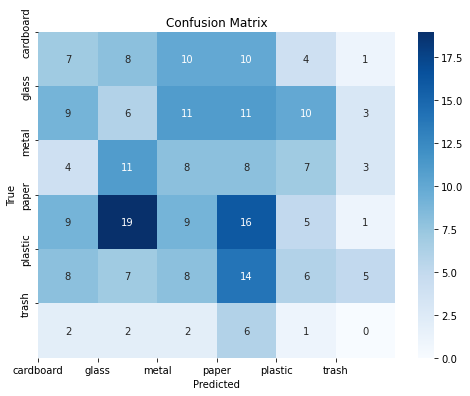

In [49]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predicted_labels = final_model.predict(test_generator).argmax(axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Print the metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Metrics for class {class_name}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-score: {f1[i]}\n")

# Calculate overall metrics
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Overall Metrics:")
print(f"Weighted Precision: {overall_precision}")
print(f"Weighted Recall: {overall_recall}")
print(f"Weighted F1-score: {overall_f1}")


Metrics for class cardboard:
Precision: 0.1794871794871795
Recall: 0.175
F1-score: 0.17721518987341775

Metrics for class glass:
Precision: 0.11320754716981132
Recall: 0.12
F1-score: 0.11650485436893204

Metrics for class metal:
Precision: 0.16666666666666666
Recall: 0.1951219512195122
F1-score: 0.17977528089887637

Metrics for class paper:
Precision: 0.24615384615384617
Recall: 0.2711864406779661
F1-score: 0.25806451612903225

Metrics for class plastic:
Precision: 0.18181818181818182
Recall: 0.125
F1-score: 0.14814814814814814

Metrics for class trash:
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Overall Metrics:
Weighted Precision: 0.17101014948868817
Weighted Recall: 0.17131474103585656
Weighted F1-score: 0.16980698961339147


3/3 [==============================] - 1s 227ms/step


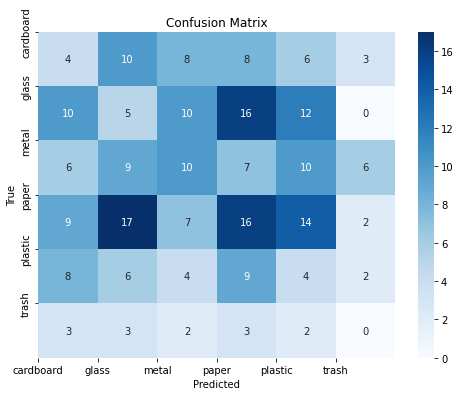

Overall Accuracy from Confusion Matrix: 0.1553784860557769


In [51]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())
predicted_labels = final_model.predict(test_generator).argmax(axis=1)

cm = confusion_matrix(predicted_labels, true_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import confusion_matrix

# Assuming you have the confusion matrix 'cm'
correct_predictions = np.diag(cm).sum()  # Sum of diagonal values (correct predictions)
total_samples = cm.sum()  # Total number of samples
accuracy = correct_predictions / total_samples

print("Overall Accuracy from Confusion Matrix:", accuracy)



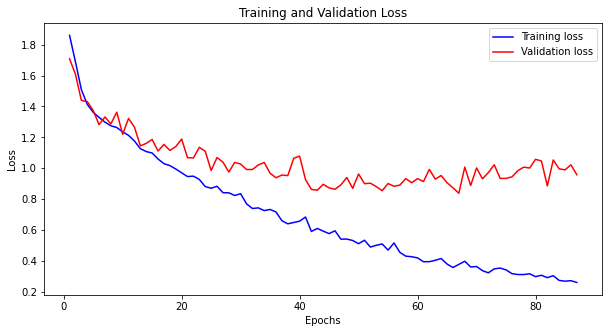

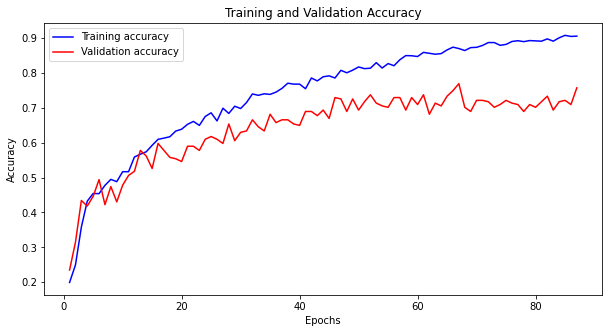

In [52]:
# Plotting training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
